In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np
import sionna 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

# proper labeling of plots
from matplotlib.ticker import EngFormatter

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

In [2]:
def random_symbols(A, N):
    """generate random symbols from the constellation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [3]:
def srrc_pulse(a, fsT, N=5):
    r"""Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - length of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [5]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

In [6]:
from scipy import special

def Q(x):
    """Gaussian error integral"""
    return 0.5 - 0.5*special.erf(x/np.sqrt(2))

In [7]:
def estimate_phasor_mf(Zk, pk):
    """Estimate phasor from matched filter outputs
    
    Inputs:
    Zk - matched filter outputs
    pk - training symbols

    Returns:
    complex scalar - estimated phasor
    """
    return np.sum(Zk * pk.conj())/np.sum(pk*pk.conj())

In [79]:

fsT = 16
N = 5
a = 0.5

pp = srrc_pulse(a, fsT, N)   # Recall that SRRC pulse is normalized to unit energy
d_samples = len(pp) - 1      # filter delay

SNR_dB = 15
SNR = 10**(SNR_dB/10)
A = 0.25
phi = np.pi/4
X = A*np.exp(1j*phi)
Alphabet = np.array([ 1.+0.j, -1.+0.j])/np.sqrt(1)
# Alphabet remains 16-QAM
Ns = 128                    # number of symbols per burst
Np = 16
pn = random_symbols(Alphabet, Np)
print(len(pn))

# simulation parameters
max_bursts = 1000
max_errors = 400

N_bursts = 0
N_errors = 0

# list for storing estimates
all_X_hat = []

16


In [81]:
# the Monte Carlo loop
while N_bursts < max_bursts and N_errors < max_errors:
    # Transmitter
    sym = random_symbols(Alphabet, Ns)
    ss = pulse_shape(np.concatenate((pn,sym)), pp, fsT)
    # Channel
    rr = X*ss + np.sqrt(0.5 * A**2/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
    # receiver
    mf_out = np.convolve(rr, np.flip(pp))
    Z = mf_out[d_samples::fsT][:Np+Ns]        # down-sample, starting at filter delay
    X_hat = estimate_phasor_mf(Z[:Np], pn)    # estimation
    # print(len(Z[:Np]))
    Z_scaled = Z[Np:]*1/X_hat
    dec = MPE_decision_rule(Z_scaled, Alphabet) # decisions on corrected symbols

    # update simulation statistics
    N_bursts += 1
    N_errors += np.sum(np.not_equal(dec, sym))
    all_X_hat.append(X_hat)

print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*Ns, N_errors/(Ns*N_bursts)))
print("The exact value for the symbol error rate is: {:8.6f}".format(Q(np.sqrt(2*SNR))))


Found 0 errors in 128000 symbols; estimated symbol error rate 0.000000
The exact value for the symbol error rate is: 0.000000


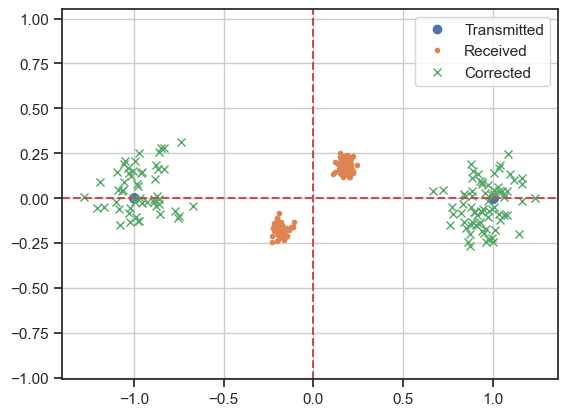

In [10]:
# Plot of constellation at different points in the process
plt.plot(np.real(sym), np.imag(sym), 'o', label="Transmitted")
plt.plot(np.real(Z[Np:]), np.imag(Z[Np:]), '.', label="Received")
plt.plot(np.real(Z_scaled), np.imag(Z_scaled), 'x', label="Corrected")
plt.grid()
# decision boundaries
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')

plt.axis('equal')
plt.legend()

plt.show()

In [140]:
ser_sims1 = []


In [141]:
#  Question 3
fsT = 16
N = 5
a = 0.5
Alphabet = np.array([ 1.+0.j, -1.+0.j])/np.sqrt(1)
pp = srrc_pulse(a, fsT, N)   # Recall that SRRC pulse is normalized to unit energy
d_samples = len(pp) - 1      # filter delay

# Alphabet remains 16-QAM
Ns = 128                    # number of symbols per burst
Np = 8
pn = random_symbols(Alphabet, Np)
avg_sym_energy = 1/Np * np.sum(np.abs(pn)**2)
# print("average symbol energy before pulse shaping: ", avg_sym_energy)

In [142]:
ser_simulated_training = []
ser_exact = []
confidence_intervals = []
snr = []
all_X_hat_full = []
# SNR loop
for SNR_dB in range(0,9,1):
    SNR = 10**(SNR_dB/10)
    A = 0.25
    phi = np.pi/4
    X = A*np.exp(1j*phi)
    # print("At SNR of", SNR_dB)
    # the Monte Carlo loop
    N_bursts = 0
    N_errors = 0  
    max_bursts = 1000
    max_errors = 400  
    all_X_hat = []
    while N_bursts < max_bursts and N_errors < max_errors:
        # Transmitter
        sym = random_symbols(Alphabet, Ns)
        ss = pulse_shape(np.concatenate((pn,sym)), pp, fsT)
        # Channel
        rr = X*ss + np.sqrt(0.5 * A**2/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
        # receiver
        mf_out = np.convolve(rr, np.flip(pp))
        Z = mf_out[d_samples::fsT][:Np+Ns]        # down-sample, starting at filter delay
        X_hat = estimate_phasor_mf(Z[:Np], pn)    # estimation
        # scale the MF outputs during the information portion
        Z_scaled = Z[Np:] * 1/X_hat
        dec = MPE_decision_rule(Z_scaled, Alphabet) # decisions on corrected symbols
        # dec = MPE_decision_rule(Z[Np:], Alphabet) # decisions on corrected symbols
        # update simulation statistics
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, sym))
        all_X_hat.append(X_hat)
    ser_theory = Q(np.sqrt(2*SNR))
    M = Ns * N_bursts  # Total symbols transmitted
    ser_sim =  N_errors/M
    # Calculate 95% confidence interval for the simulated SER
    z_c = 1.96  # 95% confidence level
    if N_errors > 0:
        s_c = z_c * np.sqrt((ser_sim * (1 - ser_sim)) / M)
    else:
        s_c = 0  # No errors, no confidence interval needed

    # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*Ns, N_errors/(Ns*N_bursts)))
    # print("The exact value for the symbol error rate is: {:8.6f}".format(Q(np.sqrt(2*SNR))))
    ser_exact.append(ser_theory)
    ser_simulated_training.append(ser_sim)
    confidence_intervals.append(s_c)
    snr.append(SNR_dB)
    all_X_hat_full.append(all_X_hat)
ser_sims1.append(ser_simulated_training)

In [143]:
ser_sims1

[[0.08614864864864864,
  0.05969929245283019,
  0.03830030487804878,
  0.024285368217054265,
  0.0125625,
  0.006578947368421052,
  0.00246875,
  0.0008359375,
  0.000234375]]

/var/folders/7y/zn2wsyn90v971fl99gkffxdh0000gn/T/ipykernel_94175/114344450.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(snr, ser_sims1[0], 'ko', marker='o', linestyle='-')


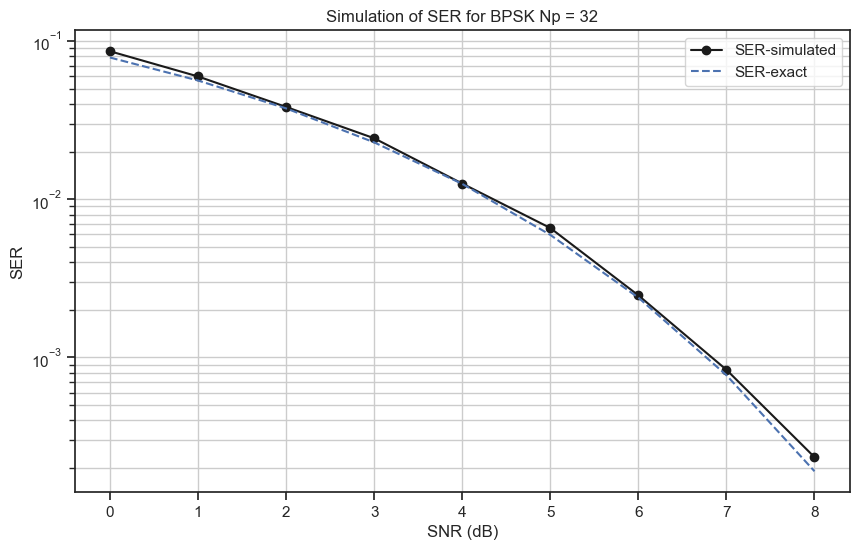

In [144]:
plt.figure(figsize=(10, 6))
plt.plot(snr, ser_sims1[0], 'ko', marker='o', linestyle='-')
plt.plot(snr, ser_exact, 'b', linestyle='--')
# Add error bars to show confidence intervals
# lower_bound = [ser - ci for ser, ci in zip(ser_sims[1], confidence_intervals)]
# upper_bound = [ser + ci for ser, ci in zip(ser_sims[1], confidence_intervals)]
# plt.errorbar(snr, ser_sims[1], yerr=confidence_intervals, fmt='o', capsize=5)
plt.yscale('log')
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('Simulation of SER for BPSK Np = 32')
plt.grid(True, which="both")  
plt.legend(['SER-simulated','SER-exact' ])

plt.show()

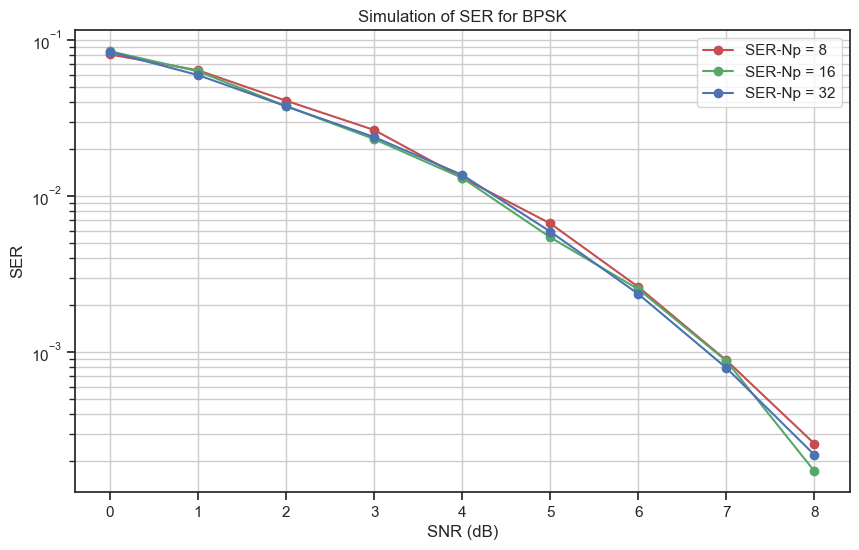

In [71]:
plt.figure(figsize=(10, 6))

# Define different colors and legends
colors = ['r', 'g', 'b', 'c', 'm']  # List of colors for each plot
legends = ['SER-Np = 8', 'SER-Np = 16', 'SER-Np = 32']  # Update legends accordingly

# Plot SNR vs errors, with a logarithmic scale for the errors
for i in range(3):
    plt.plot(snr, ser_sims[i], color=colors[i], marker='o', linestyle='-', label=legends[i])

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('Simulation of SER for BPSK')
plt.grid(True, which="both")  # Add gridlines for both major and minor ticks
plt.legend()  # Display legend with updated labels

# Show the plot
plt.show()

In [86]:
# problem 4

fsT = 16
N = 5
a = 0.5

pp = srrc_pulse(a, fsT, N)   # Recall that SRRC pulse is normalized to unit energy
d_samples = len(pp) - 1      # filter delay

SNR_dB = 5
SNR = 10**(SNR_dB/10)
A = 0.25
phi = np.pi/4
X = A*np.exp(1j*phi)
Alphabet = np.array([ 1.+0.j, -1.+0.j])/np.sqrt(1)
# Alphabet remains 16-QAM
Ns = 128                    # number of symbols per burst
Np = 8
pn = random_symbols(Alphabet, Np)
print(len(pn))
# simulation parameters
max_bursts = 1000
max_errors = 400

N_bursts = 0
N_errors = 0

# list for storing estimates
all_X_hat = []

8


In [89]:
# the Monte Carlo loop
while N_bursts < max_bursts and N_errors < max_errors:
    # Transmitter
    sym = random_symbols(Alphabet, Ns)
    ss = pulse_shape(np.concatenate((pn,sym)), pp, fsT)
    # Channel
    rr = X*ss + np.sqrt(0.5 * A**2/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
    # receiver
    mf_out = np.convolve(rr, np.flip(pp))
    Z = mf_out[d_samples::fsT][:Np+Ns]        # down-sample, starting at filter delay
    # print(len(Z))
    X_hat = estimate_phasor_mf(Z[:Np], pn)    # estimation
    # print(X_hat)
    # Use the estimate to demodulate the symbols
    b_n = np.sign(np.real(np.conjugate(X_hat) * Z[Np:]))
    # print(b_n)
    # Use both the training and the demodulated symbols to estimate the amplitude again
    pn_bn = np.concatenate((pn,b_n))
    X_hat2 = estimate_phasor_mf(Z[:Np+Ns], pn_bn) 

    # Demodulate the information symbols again
    b_n_final = np.sign(np.real(np.conjugate(X_hat2) * Z[Np:]))
    # print(len(b_n_final))
    # print(X_hat2)
    # print(len(pn_bn))

    # Z_scaled = Z[Np:]*1/X_hat
    dec = MPE_decision_rule(b_n_final, Alphabet) # decisions on corrected symbols
    
    # update simulation statistics
    N_bursts += 1
    N_errors += np.sum(np.not_equal(dec, sym))
    all_X_hat.append(X_hat)

print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*Ns, N_errors/(Ns*N_bursts)))
print("The exact value for the symbol error rate is: {:8.6f}".format(Q(np.sqrt(2*SNR))))


Found 400 errors in 69248 symbols; estimated symbol error rate 0.005776
The exact value for the symbol error rate is: 0.005954


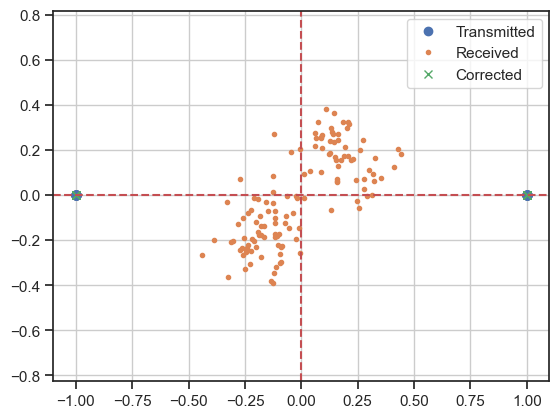

In [90]:
# Plot of constellation at different points in the process
plt.plot(np.real(sym), np.imag(sym), 'o', label="Transmitted")
plt.plot(np.real(Z[Np:]), np.imag(Z[Np:]), '.', label="Received")
plt.plot(np.real(b_n_final), np.imag(b_n_final), 'x', label="Corrected")
plt.grid()
# decision boundaries
plt.axhline(0, color='r', ls='--')
plt.axvline(0, color='r', ls='--')

plt.axis('equal')
plt.legend()

plt.show()

In [187]:
ser_sims2 = []

In [188]:
#  Question 4
fsT = 16
N = 5
a = 0.5
Alphabet = np.array([ 1.+0.j, -1.+0.j])/np.sqrt(1)
pp = srrc_pulse(a, fsT, N)   # Recall that SRRC pulse is normalized to unit energy
d_samples = len(pp) - 1      # filter delay

# Alphabet remains 16-QAM
Ns = 128                    # number of symbols per burst
Np = 32
pn = random_symbols(Alphabet, Np)
avg_sym_energy = 1/Np * np.sum(np.abs(pn)**2)
# print("average symbol energy before pulse shaping: ", avg_sym_energy)

In [189]:
ser_simulated = []
ser_exact = []
confidence_intervals = []
snr = []
all_X_hat_full = []
# SNR loop
for SNR_dB in range(0,6,1):
    SNR = 10**(SNR_dB/10)
    A = 0.25
    phi = np.pi/4
    X = A*np.exp(1j*phi)
    # print("At SNR of", SNR_dB)
    # the Monte Carlo loop
    N_bursts = 0
    N_errors = 0  
    max_bursts = 1000
    max_errors = 400  
    all_X_hat = []
    while N_bursts < max_bursts and N_errors < max_errors:
        # Transmitter
        sym = random_symbols(Alphabet, Ns)
        ss = pulse_shape(np.concatenate((pn,sym)), pp, fsT)
        # Channel
        rr = X*ss + np.sqrt(0.5 * A**2/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
        # receiver
        mf_out = np.convolve(rr, np.flip(pp))
        Z = mf_out[d_samples::fsT][:Np+Ns]        # down-sample, starting at filter delay
           # print(len(Z))
        X_hat = estimate_phasor_mf(Z[:Np], pn)    # estimation
        # print(X_hat)
        # Use the estimate to demodulate the symbols
        b_n = np.sign(np.real(np.conjugate(X_hat) * Z[Np:]))
        # print(b_n)
        # Use both the training and the demodulated symbols to estimate the amplitude again
        pn_bn = np.concatenate((pn,b_n))
        X_hat2 = estimate_phasor_mf(Z, pn_bn) 

        # Demodulate the information symbols again
        b_n_final = np.sign(np.real(np.conjugate(X_hat2) * Z[Np:]))
        dec = MPE_decision_rule(b_n_final, Alphabet) # decisions on corrected symbols
        # update simulation statistics
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, sym))
        all_X_hat.append(X_hat)
    ser_theory = Q(np.sqrt(2*SNR))
    M = Ns * N_bursts  # Total symbols transmitted
    ser_sim =  N_errors/M
    # Calculate 95% confidence interval for the simulated SER
    z_c = 1.96  # 95% confidence level
    if N_errors > 0:
        s_c = z_c * np.sqrt((ser_sim * (1 - ser_sim)) / M)
    else:
        s_c = 0  # No errors, no confidence interval needed

    # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*Ns, N_errors/(Ns*N_bursts)))
    # print("The exact value for the symbol error rate is: {:8.6f}".format(Q(np.sqrt(2*SNR))))
    ser_exact.append(ser_theory)
    ser_simulated.append(ser_sim)
    confidence_intervals.append(s_c)
    snr.append(SNR_dB)
    all_X_hat_full.append(all_X_hat)
ser_sims2.append(ser_simulated)

/var/folders/7y/zn2wsyn90v971fl99gkffxdh0000gn/T/ipykernel_94175/2420860346.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  dec[n] = A[ind]


In [190]:
ser_sims2

[[0.07477678571428571,
  0.05724431818181818,
  0.038580246913580245,
  0.024987599206349208,
  0.013412017167381975,
  0.00625]]

/var/folders/7y/zn2wsyn90v971fl99gkffxdh0000gn/T/ipykernel_94175/1284031164.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(snr, ser_sims1[0][:6], 'ko', marker='o', linestyle='-')


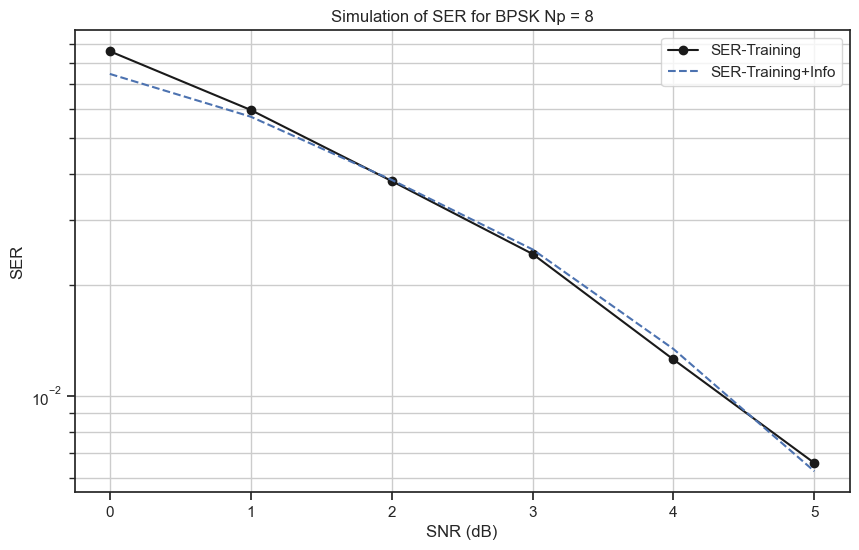

In [191]:
plt.figure(figsize=(10, 6))
plt.plot(snr, ser_sims1[0][:6], 'ko', marker='o', linestyle='-')
plt.plot(snr, ser_sims2[0], 'b', linestyle='--')
# Add error bars to show confidence intervals
# lower_bound = [ser - ci for ser, ci in zip(ser_simulated, confidence_intervals)]
# upper_bound = [ser + ci for ser, ci in zip(ser_simulated, confidence_intervals)]
# plt.errorbar(snr, ser_simulated, yerr=confidence_intervals, fmt='o', capsize=5)
plt.yscale('log')
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('Simulation of SER for BPSK Np = 8')
plt.grid(True, which="both")  
plt.legend(['SER-Training','SER-Training+Info' ])

plt.show()

In [192]:
ser_sims3 = []

In [193]:
#  Question 4b
fsT = 16
N = 5
a = 0.5
Alphabet = np.array([ 1.+0.j, -1.+0.j])/np.sqrt(1)
pp = srrc_pulse(a, fsT, N)   # Recall that SRRC pulse is normalized to unit energy
d_samples = len(pp) - 1      # filter delay

# Alphabet remains 16-QAM
Ns = 128                    # number of symbols per burst
Np = 32
pn = random_symbols(Alphabet, Np)
avg_sym_energy = 1/Np * np.sum(np.abs(pn)**2)
# print("average symbol energy before pulse shaping: ", avg_sym_energy)

In [194]:
ser_simulated = []
ser_exact = []
confidence_intervals = []
snr = []
all_X_hat_full = []
# SNR loop
for SNR_dB in range(0,6,1):
    SNR = 10**(SNR_dB/10)
    A = 0.25
    phi = np.pi/4
    X = A*np.exp(1j*phi)
    # print("At SNR of", SNR_dB)
    # the Monte Carlo loop
    N_bursts = 0
    N_errors = 0  
    max_bursts = 1000
    max_errors = 400  
    all_X_hat = []
    while N_bursts < max_bursts and N_errors < max_errors:
        # Transmitter
        sym = random_symbols(Alphabet, Ns)
        ss = pulse_shape(np.concatenate((pn,sym)), pp, fsT)
        # Channel
        rr = X*ss + np.sqrt(0.5 * A**2/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
        # receiver
        mf_out = np.convolve(rr, np.flip(pp))
        Z = mf_out[d_samples::fsT][:Np+Ns]        # down-sample, starting at filter delay
        X_hat = estimate_phasor_mf(Z[:Np], pn)    # estimation
        # Use the estimate to perform soft decisions to demodulate the symbols
        # b_n = np.sign(np.real(np.conjugate(X_hat) * Z[Np:]))
        sigma_sq = A**2/SNR
        b_n = np.tanh(np.real(np.conj(X_hat)*Z[Np:])/sigma_sq)
        dec = MPE_decision_rule(b_n, Alphabet) # decisions on corrected symbols
        # update simulation statistics
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, sym))
        all_X_hat.append(X_hat)
    ser_theory = Q(np.sqrt(2*SNR))
    M = Ns * N_bursts  # Total symbols transmitted
    ser_sim =  N_errors/M
    # Calculate 95% confidence interval for the simulated SER
    z_c = 1.96  # 95% confidence level
    if N_errors > 0:
        s_c = z_c * np.sqrt((ser_sim * (1 - ser_sim)) / M)
    else:
        s_c = 0  # No errors, no confidence interval needed

    # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*Ns, N_errors/(Ns*N_bursts)))
    # print("The exact value for the symbol error rate is: {:8.6f}".format(Q(np.sqrt(2*SNR))))
    ser_exact.append(ser_theory)
    ser_simulated.append(ser_sim)
    confidence_intervals.append(s_c)
    snr.append(SNR_dB)
    all_X_hat_full.append(all_X_hat)
ser_sims3.append(ser_simulated)

/var/folders/7y/zn2wsyn90v971fl99gkffxdh0000gn/T/ipykernel_94175/2420860346.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  dec[n] = A[ind]


/var/folders/7y/zn2wsyn90v971fl99gkffxdh0000gn/T/ipykernel_94175/4076495146.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(snr, ser_sims2[0], 'ko', marker='o', linestyle='-')


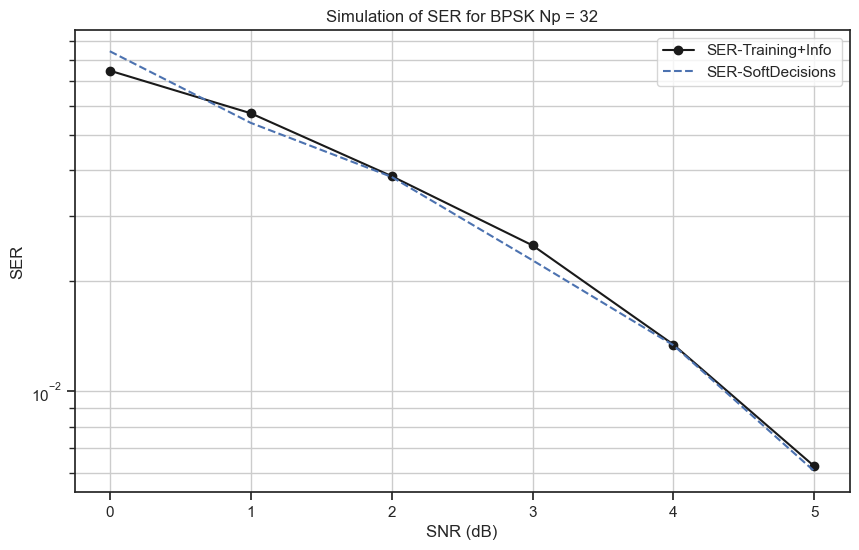

In [195]:
plt.figure(figsize=(10, 6))
plt.plot(snr, ser_sims2[0], 'ko', marker='o', linestyle='-')
plt.plot(snr, ser_sims3[0], 'b', linestyle='--')
plt.yscale('log')
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('Simulation of SER for BPSK Np = 32')
plt.grid(True, which="both")  
plt.legend(['SER-Training+Info','SER-SoftDecisions' ])

plt.show()